In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

% matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 12.0) 

In [2]:
def defineShellRadii(nTot=1000.,rOut=1000.,nAnn=10,k=3):
    radii = np.array([1.])
    if k==3:
        nu0 = nTot/(4*np.pi*np.log(rOut))
        c = nTot/(nAnn*4*np.pi*nu0)
    else:
        nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
        c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
        
    for i in range(nAnn):
        if k==3:
            radii = np.append(radii,np.exp(c+np.log(radii[i])))
        else:
            radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii

def sigmaProfile(radii,sigMax=1000,k=-.2):
    return sigMax*(0.5*(radii[1:]+radii[:-1]))**k

In [3]:
def createMockData(Ntot=1000,rOut=1000.,nAnn=10,sigMax=1000,kindex=3.,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((2*Ntot,2))
    counter=0
    radii = defineShellRadii(Ntot,rOut,nAnn,kindex)
    #density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax,k=sigmaindex)
    
    for shell,dens in enumerate(np.random.poisson(Ntot/nAnn*np.ones(nAnn))):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        theta = np.arccos(np.random.uniform(-1,1,dens))
        r = np.power(np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens),1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        #z = r*cosTheta
        
        radius = np.sqrt(np.power(x,2.)+np.power(y,2.))
        #generate velocities
                
        v=sig[shell]*np.random.randn(dens)*np.random.uniform(-1,1,dens)
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((radius.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    #print 'Created mock data with '+str(counter)+' galaxies.'
    return pd.DataFrame(clusterData[:counter],columns=['r','vobs'])

In [4]:
def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]

In [18]:
def createProfiles(annuli,ngals,rout,nshells,sigMax,kInd,sInd):
    mockData = createMockData(ngals,rout,nshells,sigMax,kInd,sigInd)
    mockData['annuli'] = labelGalaxies(mockData,annuli)
    return galInAnn(mockData,annuli),sigInAnn(mockData,annuli)


In [19]:
ntot = 1000
rout = 1000
nshells = 10
sigMax = 1000
kInd = 3.
sigInd = -0.2

mockData = createMockData(ntot,rout,nshells,sigMax,kInd,sigInd)

nAnn = 10 #number of desired annuli
annuli = defineAnnuli(mockData['r'],nAnn+1)

nArray,sigArray = createProfiles(annuli,ntot,rout,nshells,sigMax,kInd,sigInd)

In [20]:
lot = 100

for i in range(lot):
    bla1,bla2 = createProfiles(annuli,ntot,rout,nshells,sigMax,kInd,sigInd)
    nArray = np.vstack((nArray,bla1))
    sigArray = np.vstack((sigArray,bla2))

In [21]:
galsPerBin = np.linspace(0,150,16)

print nArray[:,0]

np.histogram(nArray[:,0],bins=galsPerBin,density=True)

[ 91  88 102 101 107 107  97 110 100 100 101  99  99  91  95 102  87  83
 101  87  96 109 106  94  81 100  81  89 110 107  98 102  80 103  97  99
  96 107 101 112  95 102  96 116  88 116 101 100 114 114  99 112 113  93
 103  93  93  95 106  85  95 104 101 114 108 104 119 106  90 102  81  90
 111  78 114  82  98 108 120 106  97  99  83 104  84 105  95  82  98 108
  96 108 101 107 101 110 115 108 115  97 102]


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.0009901 ,  0.01485149,  0.02871287,
         0.03861386,  0.01584158,  0.0009901 ,  0.        ,  0.        ]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.]))

/home/ondrej/anaconda/lib/python2.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:2371: UserWarning: x, y, and z must be the same length.
  warnings.warn('x, y, and z must be the same length.')


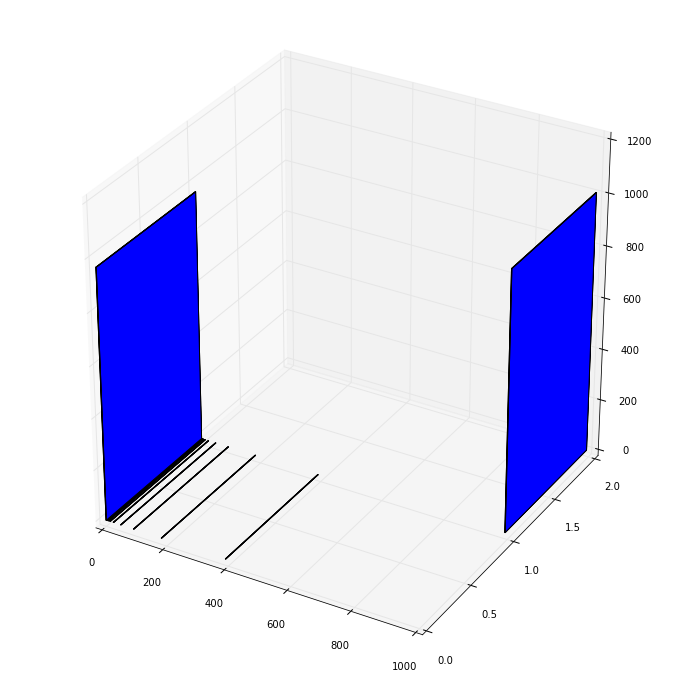

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rData, nData = np.meshgrid( np.arange(nArray.shape[1]),
                              np.arange(nArray.shape[0]) )
rData = annuli
rData = rData.flatten()
nData = nData.flatten()
zData = nArray.flatten()
ax.bar3d( rData,
          nData,
          np.zeros(len(zData)),
          1, 1, zData )

